# Load In

In [ ]:
!apt install subversion --quiet
!pip install adjustText --quiet
!pip install shap --quiet
!pip install scikit-garden --quiet

Reading package lists...
Building dependency tree...
Reading state information...
subversion is already the newest version (1.9.7-4ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
     |████████████████████████████████| 276kB 3.4MB/s 
     |████████████████████████████████| 317kB 3.4MB/s 


In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)

In [ ]:
import time
from joblib import dump, load
import random
import requests
import json
import datetime
import os
import re
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.model_selection import KFold 

from scipy.stats import pearsonr

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
nflfastr_dir = '/content/drive/My Drive/nflfastR-data'
data_type = '.parquet'
files_to_load = [f"{nflfastr_dir}/data/{x}" for x in os.listdir(f"{nflfastr_dir}/data") if x.endswith(data_type)]

# this loads the data into a `pandas` dataframe and appends each file to the dataframe  
df = pd.DataFrame()
for fn in files_to_load:
  _df = pd.read_parquet(fn) 
  df = df.append(_df,ignore_index=True)

# this is for verification that we loaded in a bunch of data. This is the rows X columns of the dataframe
print(df.shape)

(996549, 322)


(48034, 322)

# Data Play

My first thought when it comes to making an adjusted EPA value is super menial. What I'll do is find the average EPA/Play value for each defense, for both run and pass plays. I'll merge this dataframe into the play by play data frame, and create a new weighted value from `EPA` -`weight` to produce an adjusted value.

First let's clean the data

In [ ]:
df = df.dropna(subset=['epa']).loc[~(df['play_type']=='no_play')& ((df['rush']==1)|(df['pass']==1)) & (df['season']>=2002)]
df.shape

(368322, 322)

Now we'll find our weights


In [ ]:
weights = df.loc[:,['epa','play_type','defteam','season']].groupby(['defteam','play_type','season'],as_index=False).agg({'epa':'mean'})
weights = weights.rename(columns={'epa':'weight'})
weights.columns

Merge them together

In [ ]:
df_adj = pd.merge(df, weights[['defteam','play_type','season','weight']],on=['defteam','play_type','season'])

Make the adjustment

In [ ]:
df_adj['adj_epa'] = df_adj['epa'].sub(df_adj['weight'])
df_adj['change'] = df_adj['adj_epa'].sub(df_adj['epa'])


In [ ]:
df_adj = df_adj.loc[:,['posteam','epa','adj_epa','change','play_type','season']].groupby(['posteam','season'],as_index=False).agg({'epa':'mean','adj_epa':'mean','change':'mean'})
df_adj = df_adj.rename(columns=({'posteam':'team'}))

In [ ]:
df_adj = df_adj.sort_values('epa',ascending=False)


# Add Wins to the DF

In [ ]:
wins = pd.read_csv('/content/standings_fixed.csv')

In [ ]:
results = pd.merge(df_adj, wins[['team','wins','season']],on=['team','season'])

In [ ]:
results.sort_values('adj_epa',ascending=False)

,team,season,epa,adj_epa,change,wins
7,NE,2010,0.187443,0.220615,0.033172,14
0,KC,2018,0.234318,0.205826,-0.028492,12
1,NO,2011,0.226899,0.202517,-0.024382,13
2,ATL,2016,0.213546,0.199020,-0.014526,11
6,BAL,2019,0.192763,0.198843,0.006081,14
...,...,...,...,...,...,...
332,ARI,2010,-0.194537,-0.202087,-0.007551,5
335,CAR,2010,-0.237441,-0.213280,0.024161,2
333,LA,2016,-0.214799,-0.236844,-0.022045,4
336,ARI,2012,-0.243670,-0.241615,0.002055,5


# R^2 Time😎

In [ ]:
def  epa_plot(x,y,title,data,color='k'):
  _data = data.dropna(subset=[x,y]) 
  r2 = pearsonr(_data.loc[:,x],_data.loc[:,y])[0]**2 
  rmse = mean_squared_error(_data.loc[:,x],_data.loc[:,y])**0.5 
  f = sns.regplot(x,y,data=_data,color=color,line_kws={'color':'k'})
  # f.set_aspect('equal')
  sns.despine()
  plt.title(f'{title}\nR2: {round(r2,3)}\nRMSE: {round(rmse,3)}')
  plt.show()

In [ ]:
palette = sns.palettes.hls_palette(10)

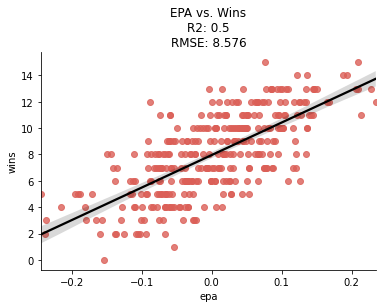

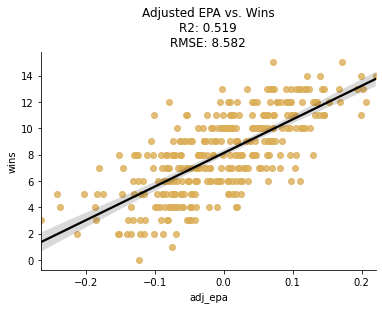

In [ ]:
epa_plot('epa','wins','EPA vs. Wins',results,color=palette[0])
epa_plot('adj_epa','wins','Adjusted EPA vs. Wins',results,color=palette[1])

# Attempt #2

I'm thinking since we've seen the effectiveness of the adjustment on only pass/rush plays, I'm gonna try and expand it to include special teams as well.

In [ ]:
nflfastr_dir = '/content/drive/My Drive/nflfastR-data'
data_type = '.parquet'
files_to_load = [f"{nflfastr_dir}/data/{x}" for x in os.listdir(f"{nflfastr_dir}/data") if x.endswith(data_type)]

# this loads the data into a `pandas` dataframe and appends each file to the dataframe  
df2 = pd.DataFrame()
for fn in files_to_load:
  _df = pd.read_parquet(fn) 
  df2 = df2.append(_df,ignore_index=True)

# this is for verification that we loaded in a bunch of data. This is the rows X columns of the dataframe
print(df2.shape)

(996549, 322)


In [ ]:
df2.play_type.values

array([None, 'kickoff', 'pass', ..., 'no_play', 'qb_kneel', None],
      dtype=object)

In [ ]:
pt = df2.loc[:,['play_type','play_id']].groupby('play_type',as_index=False).agg({'play_id':'count'})

In [ ]:
pt

,play_type,play_id
0,extra_point,25252
1,field_goal,21092
2,kickoff,54946
3,no_play,92806
4,pass,400290
5,punt,52978
6,qb_kneel,7265
7,qb_spike,1439
8,run,297125


I think it is only really necessary to take into account the following plays:
*   Extra Point
*   FG
*   Kickoff
*   Pass
*   Punt
*   Run

In [ ]:
df3 = df2.dropna(subset=['epa']).loc[~(df2['play_type']=='no_play')& ~(df2['play_type']=='qb_kneel') & ~(df2['play_type']=='qb_spike') & (df2['season']>=2002)]

In [ ]:
pt2 = df3.loc[:,['play_type','play_id']].groupby('play_type',as_index=False).agg({'play_id':'count'})
pt2

,play_type,play_id
0,extra_point,22034
1,field_goal,18103
2,kickoff,47560
3,pass,344542
4,punt,45037
5,run,254221


Sweeeet so now we have just the plays we're looking for. Let's make the weights again.

In [ ]:
weights2 = df3.loc[:,['epa','play_type','defteam','season']].groupby(['defteam','play_type','season'],as_index=False).agg({'epa':'mean'})
weights2 = weights2.rename(columns={'epa':'weight'})
weights2.columns

Index(['defteam', 'play_type', 'season', 'weight'], dtype='object')

In [ ]:
df3_adj = pd.merge(df3, weights2[['defteam','play_type','season','weight']],on=['defteam','play_type','season'])

In [ ]:
df3_adj['adj_epa'] = df3_adj['epa'].sub(df3_adj['weight'])
df3_adj['change'] = df3_adj['adj_epa'].sub(df3_adj['epa'])


In [ ]:
df3_adj = df3_adj.loc[:,['posteam','epa','adj_epa','change','play_type','season']].groupby(['posteam','season'],as_index=False).agg({'epa':'mean','adj_epa':'mean','change':'mean'})
df3_adj = df3_adj.rename(columns=({'posteam':'team'}))

In [ ]:
df3_adj = df3_adj.sort_values('epa',ascending=False)
df3_adj

,team,season,epa,adj_epa,change
383,NE,2007,0.231204,0.212826,-0.018379
236,IND,2004,0.206457,0.170579,-0.035877
286,KC,2018,0.201777,0.184563,-0.017214
387,NE,2011,0.198405,0.176159,-0.022246
405,NO,2011,0.194876,0.170275,-0.024600
...,...,...,...,...,...
297,LA,2011,-0.168364,-0.149384,0.018979
80,CAR,2010,-0.173095,-0.172459,0.000636
92,CHI,2004,-0.176987,-0.229572,-0.052585
328,LV,2006,-0.186084,-0.192761,-0.006678


In [ ]:
results2 = pd.merge(df3_adj, wins[['team','wins','season']],on=['team','season'])
results2.sort_values('adj_epa',ascending=False)

,team,season,epa,adj_epa,change,wins
0,NE,2007,0.231204,0.212826,-0.018379,16
6,NE,2010,0.194236,0.197561,0.003325,14
2,KC,2018,0.201777,0.184563,-0.017214,12
7,ATL,2016,0.189197,0.181698,-0.007499,11
12,BAL,2019,0.165633,0.179850,0.014216,14
...,...,...,...,...,...,...
565,HOU,2002,-0.149033,-0.168774,-0.019742,4
572,CAR,2010,-0.173095,-0.172459,0.000636,2
574,LV,2006,-0.186084,-0.192761,-0.006678,2
575,ARI,2018,-0.206545,-0.212768,-0.006223,3


In [ ]:
def  epa_plot(x,y,title,data,color='k'):
  _data = data.dropna(subset=[x,y]) 
  r2 = pearsonr(_data.loc[:,x],_data.loc[:,y])[0]**2 
  rmse = mean_squared_error(_data.loc[:,x],_data.loc[:,y])**0.5 
  f = sns.regplot(x,y,data=_data,color=color,line_kws={'color':'k'})
  # f.set_aspect('equal')
  sns.despine()
  plt.title(f'{title}\nR2: {round(r2,3)}\nRMSE: {round(rmse,3)}')
  plt.show()

In [ ]:
palette = sns.palettes.hls_palette(10)

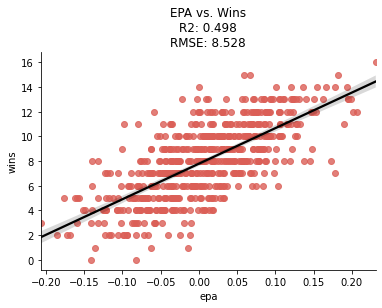

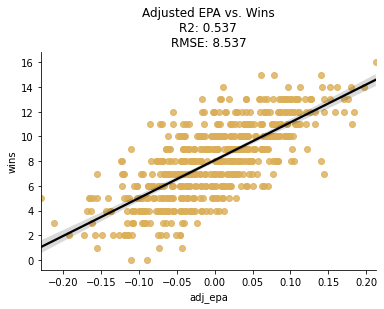

In [ ]:
epa_plot('epa','wins','EPA vs. Wins',results2,color=palette[0])
epa_plot('adj_epa','wins','Adjusted EPA vs. Wins',results2,color=palette[1])